In [1]:
from parcels import (
    AdvectionRK4_3D,
    ErrorCode,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
    plotTrajectoriesFile
)

from operator import attrgetter
from datetime import datetime, timedelta

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf

fatal: not a git repository (or any of the parent directories): .git


In [2]:
# Parameters

##### release position 
release_zone = "test_4000"
bathymodiolus_delta_lat = 0.6 #seamount diameter

#release_depth = 2

# release particles
number_particles = 10000

# release timing
release_time_in_days = 1   # e.g. from 01/01/2009 to 03/01/2009 
start_year = 2009
start_month = 1
start_day = 1

# experiment duration etc
runtime_in_days = 30
dt_in_minutes = 60

# particle positions are stored every x hours 
outputdt_in_hours = 24

# release location file
release_locations_file = "../data/config/test_stations.csv"

# location of input data
data_path = '../data/config/'#'/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/'
experiment_name = 'ROMS' 
data_resolution = '1d'
mesh_path = '/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/'

# names of files to load
fname = 'roms_avg01_2009_datetime.nc'
depthfile = 'sigma2depth_parent.nc'
meshfile = 'roms_grd2_1500mVT1.nc'

# location of output data
outpath = f'../output_data/{experiment_name}'
output_filename = '{release_zone}_{start_year}{start_month:02d}{start_day:02d}_RT-{runtime_in_days}_N-{number_particles}_seed-{RNG_seed}.nc'

# how to initialize the random number generator
RNG_seed = 12345


In [3]:
# remove spaces and lower the input from csv file
release_zone = release_zone.lower().replace(' ', '-').replace("'", '-')

# correct runtime
corrected_runtime_in_days = runtime_in_days + release_time_in_days

### Construct input / output paths etc.

In [4]:
data_path = Path(data_path)
mesh_path = Path(mesh_path)
depth_path = data_path
#mesh_mask = mask_path / experiment_name / fname

outpath = Path(outpath)

output_filename = output_filename.format(
    release_zone = release_zone,
    RNG_seed=RNG_seed,
    start_year=start_year,
    start_month = start_month,
    start_day = start_day,
    runtime_in_days = runtime_in_days,
    number_particles=number_particles
)
outfile = outpath / output_filename
outfile

PosixPath('../output_data/ROMS/test_4000_20090101_RT-30_N-10000_seed-12345.nc')

### Load release location

In [5]:
def load_release_locations(release_locations_file):
    df = pd.read_csv(release_locations_file, delimiter=",")
    df = df.set_index("release_zone")
    df.index = df.index.str.lower().str.replace(' ', '-').str.replace("'", '-')
    return df

In [6]:
release_locations = load_release_locations(release_locations_file)
bathymodiolus_lat, bathymodiolus_lon, release_depth = release_locations.loc[release_zone]
bathymodiolus_delta_lon = bathymodiolus_delta_lat * np.cos(np.deg2rad(bathymodiolus_lat))

bathymodiolus_lat, bathymodiolus_lon, release_depth

(-23.25, 8.25, 4000.0)

### Fieldset

In [7]:
def fieldset_definitions(
    data_file, mesh_file, depth_file 
):
    
    filenames = {'U': {'lon': mesh_file, 'lat': mesh_file, 'depth': depth_file, 'data': data_file},
                 'V': {'lon': mesh_file, 'lat': mesh_file, 'depth': depth_file, 'data': data_file},
                 'W': {'lon': mesh_file, 'lat': mesh_file, 'depth': depth_file, 'data': data_file},
                 'T': {'lon': mesh_file, 'lat': mesh_file, 'depth': depth_file, 'data': data_file},
                }

    variables = {'U': 'u',
                 'V': 'v',
                 'W': 'w',
                 'T': 'temp'
                }
    
    dimensions = {'lon': 'lon_psi', 'lat': 'lat_psi', 'depth': 'hs', 'time': 'time'}
    
    return FieldSet.from_c_grid_dataset(
        filenames, variables, dimensions,
        chunksize=False,
        mesh='spherical',
        tracer_interp_method='cgrid_tracer',
        allow_time_extrapolation=True
    )

In [8]:
def create_fieldset(
    data_path=data_path, mesh_path=mesh_path, depth_path=depth_path, experiment_name=experiment_name,
    fname=fname, meshfile=meshfile, depthfile=depthfile
):
    
    data = list(sorted((data_path / experiment_name).glob(fname)))
    mesh = list(sorted((mesh_path / experiment_name).glob(meshfile)))
    depth = list(sorted((depth_path / experiment_name).glob(depthfile)))
    
    fieldset = fieldset_definitions(
        data, mesh, depth)
    return fieldset

In [9]:
fieldset = create_fieldset()

In [10]:
print(type(fieldset.U.grid))
assert fieldset.U.grid is fieldset.V.grid
assert fieldset.U.grid is fieldset.W.grid

<class 'parcels.grid.RectilinearSGrid'>


In [11]:
fieldset.computeTimeChunk(time=fieldset.U.grid.time[0], dt=1)
print(fieldset.U.data.shape)
print(fieldset.U.grid.lon.shape)
print(fieldset.U.grid.lat.shape)
print(fieldset.U.grid.depth.shape)

(2, 32, 257, 237)
(237,)
(257,)
(32, 257, 237)


In [12]:
fieldset

In [13]:
print(fieldset.U.grid.depth[:,20,0])

[1396.8757   1384.7084   1369.9467   1352.1112   1330.6694   1305.0474
 1274.6512   1238.9001   1197.2747   1149.3776   1095.0068   1034.2303
  967.45197   895.4517    819.3852    740.73145   661.18933   582.5356
  506.4691    434.46884   367.69043   306.91394   252.5432    204.64613
  163.02061   127.269585   96.8734     71.25141    49.809605   31.974112
   17.212467    5.045076]


### Create a set of particles with random initial positions

In [14]:
np.random.seed(RNG_seed)

time = np.sort(
        datetime(start_year, start_month, start_day)
        + timedelta(hours=1) * np.random.randint(
            0, (release_time_in_days) * 24 * 60 / dt_in_minutes, size=(number_particles, )
        )
)

depth = np.ones(time.size) * release_depth 

In [15]:
def get_uniform_random_in_cube(
    lat_start=bathymodiolus_lat-bathymodiolus_delta_lat, lat_end=bathymodiolus_lat+bathymodiolus_delta_lat,
    lon_start=bathymodiolus_lon-bathymodiolus_delta_lon, lon_end=bathymodiolus_lon+bathymodiolus_delta_lon,
    N=10,
):
    lat = np.rad2deg(
        np.arcsin(
            np.random.uniform(
                np.sin(np.deg2rad(lat_start)),
                np.sin(np.deg2rad(lat_end)),
                size=(N, ),
            )
        )
    )
    lon = np.random.uniform(lon_start, lon_end, size=(N, ))
    
    return pd.DataFrame(
        {
            "lat": lat,
            "lon": lon,
        }
    )

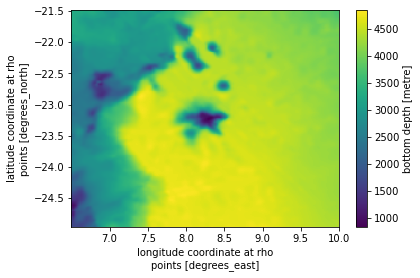

In [16]:
SIGMA=xr.open_dataset('/gxfs_work1/geomar/smomw523/master-thesis/data/config/ROMS/sigma2depth_parent.nc')
topo_ROMS = SIGMA['h']
topo_ROMS = topo_ROMS.rename({'lat_rho': 'lat','lon_rho': 'lon'})

topo_ROMS.plot()

In [17]:
release_points = get_uniform_random_in_cube(N=20*number_particles,
)
release_points["topo_ROMS"] = topo_ROMS.sel(
    lat=release_points.to_xarray().lat,
    lon=release_points.to_xarray().lon,
    method="nearest",
)
release_points = release_points.where(release_points.topo_ROMS > release_depth).dropna().iloc[:number_particles].reset_index(drop=True)

In [18]:
release_points

,lat,lon,topo_ROMS
0,-22.672552,8.338248,4499.302246
1,-23.333166,8.777332,4514.511719
2,-22.783077,8.237250,4461.183105
3,-23.504497,8.578305,4591.753906
4,-22.715008,8.727002,4452.540039
...,...,...,...
9995,-23.278553,8.718306,4516.642090
9996,-22.817759,7.895718,4531.419922
9997,-23.725452,7.725133,4688.137207
9998,-23.550565,8.378504,4684.571289


In [19]:
print(time[:5])

[datetime.datetime(2009, 1, 1, 0, 0) datetime.datetime(2009, 1, 1, 0, 0)
 datetime.datetime(2009, 1, 1, 0, 0) datetime.datetime(2009, 1, 1, 0, 0)
 datetime.datetime(2009, 1, 1, 0, 0)]


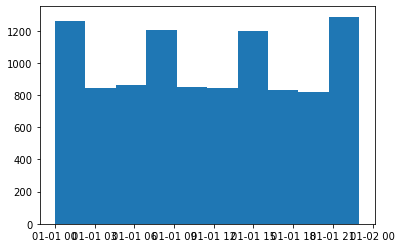

In [20]:
plt.hist(time, bins=10);

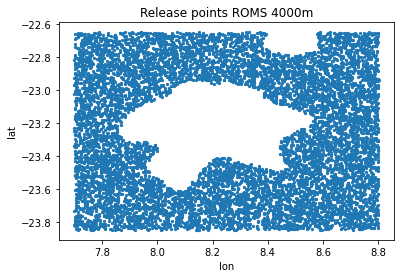

In [21]:
plt.scatter(release_points.lon, release_points.lat, s=5)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('Release points ROMS 4000m')

plt.savefig(('../output_data/{experiment_name}/plots/release-points_{release_zone}_{start_year}{start_month:02d}{start_day:02d}_RT-{runtime_in_days}_N-{number_particles}_seed-{RNG_seed}.png').format(
    experiment_name = experiment_name,
    release_zone = release_zone,
    RNG_seed=RNG_seed,
    start_year=start_year,
    start_month = start_month,
    start_day = start_day,
    runtime_in_days = runtime_in_days,
    number_particles=number_particles)
           )

plt.show;

In [22]:
fieldset.U.grid.time_full = fieldset.U.grid.time_full.astype(np.float64)
# This next line shouldn't be necessary. But there was a bug at some time apparently

In [23]:
%%time
pset = ParticleSet(
    fieldset=fieldset,
    pclass=JITParticle, #SampleParticle später? muss dann vorher auch def werden,
    lat=release_points.lat,
    lon=release_points.lon,
    depth=depth,
    time=time
)
print(pset[0])

P[0](lon=8.338248, lat=-22.672552, depth=4000.000000, time=0.000000)
CPU times: user 74.8 ms, sys: 1 ms, total: 75.8 ms
Wall time: 75.5 ms


In [24]:
kernel = pset.Kernel(AdvectionRK4_3D)

### Be able to handle errors during integration

In [25]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()
    
recovery_cases = {ErrorCode.ErrorOutOfBounds: DeleteParticle,
    ErrorCode.ErrorThroughSurface: DeleteParticle
    }

In [26]:
outfile

PosixPath('../output_data/ROMS/test_4000_20090101_RT-30_N-10000_seed-12345.nc')

In [27]:
output_pfile = pset.ParticleFile(name=outfile, outputdt=timedelta(hours=outputdt_in_hours))

In [28]:
pset.execute(
    kernel,
    runtime=timedelta(days=corrected_runtime_in_days),
    dt=timedelta(minutes=dt_in_minutes),
    output_file=output_pfile,
    recovery=recovery_cases,
)

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /tmp/parcels-726810/lib185272ab5622f73c0605f0162d26342d_0.so
INFO: Temporary output files are stored in ../output_data/ROMS/out-FNEBSTLS.
INFO: You can use "parcels_convert_npydir_to_netcdf ../output_data/ROMS/out-FNEBSTLS" to convert these to a NetCDF file during the run.
100%|██████████████████████████| 2678400.0/2678400.0 [01:24<00:00, 31721.32it/s]


### Errors at bottom:
* Particle P[23](lon=8.339165, lat=-23.223385, depth=936.193193, time=216000.000000)
  
  Time: 2009-01-03T12:00:00.000000000,	timestep dt: 3600.000000
  
  Through-surface sampling by particle at (8.339165, -23.223385, 936.193193)

### Errors at surface:
* Particle P[4](lon=8.254837, lat=-23.426231, depth=10.000000, time=0.000000)
   
  Time: 2009-01-01T00:00:00.000000000,	timestep dt: 3600.000000
  
  Out-of-bounds sampling by particle at (8.254837, -23.426231, 10.000000)

In [29]:
output_pfile.export()

In [30]:
particle_ds = xr.open_dataset(outfile)
particle_ds

<xarray.Dataset>
Dimensions:     (traj: 10000, obs: 32)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 ...
    lat         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

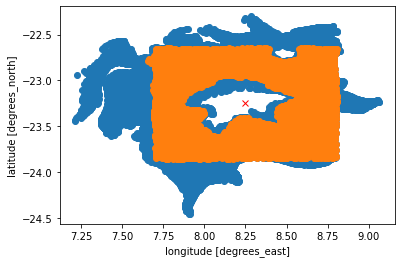

In [31]:
particle_ds.plot.scatter(x="lon", y="lat")
particle_ds.isel(obs=0).plot.scatter(x="lon", y="lat")
plt.plot(bathymodiolus_lon, bathymodiolus_lat, 'rx')

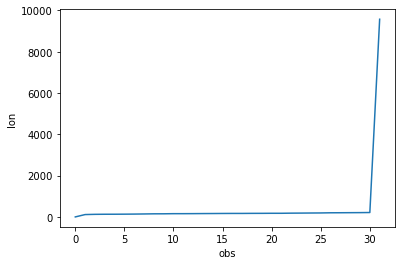

In [32]:
particle_ds.lon.isnull().sum("traj").plot()